# Big Data Analysis Project - Data Exploratory Analysis

### This is a course project for Concordia's Bigdata class (SOEN691 UU) by Dr. Tristan Glatard in Winter 2020.
*Team Members:*
- Le, Manh Quoc Dat (Student ID: 40153127)<br />
- Tran, Trong Tuan (Student ID: 40151694)<br />
- Phan, Vu Hong Hai (Student ID: 40154023)<br />
- Zhang, Yefei (Student ID: 40153319)<br />

Main project repository: https://github.com/HongHaiPV/concordia-bigdata-project <br />
Datasource: https://sites.google.com/eng.ucsd.edu/fitrec-project/home <br />
(Jianmo Ni, Larry Muhlstein, and Julian McAuley, “Modeling Heart Rate and Activity Data for Personalized Fitness Recommendation,” in The World Wide Web Conference on - WWW’19, San Francisco, CA, USA, 2019, pp. 1343–1353, doi: 10.1145/3308558.3313643.)

### A. Initialize pyspark framework and load data into pyspark's dataframe
Load data set into spark dataframe:<br />
   *(Note: the raw data and metadata files are download from the source above, unzipped and put into 'data' folder)*

In [120]:
import os
import sys
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit
from pyspark.sql.functions import desc
from pyspark.sql.functions import col
from pyspark.sql.functions import size
import pandas as pd
from pandas import DataFrame
from IPython.core.interactiveshell import InteractiveShell
import matplotlib
InteractiveShell.ast_node_interactivity = "all" # This helps auto print out the items without explixitly using 'print'

# Initialize a spark session.

conf = pyspark.SparkConf().setMaster("local[*]")
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("BigData Project - Exploratory Analysis") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = './data/endomondoHR.json'
filename_metadata = './data/endomondoMeta.json'
df = spark.read.json(filename_data, mode="DROPMALFORMED")
df_meta = spark.read.json(filename_metadata, mode="DROPMALFORMED")
type(df)

pyspark.sql.dataframe.DataFrame

### B. Let's have an overview of the raw data set
(@) Columns & types:

In [3]:
print('Columns & datatypes:')
dataframe = DataFrame(df.dtypes, columns =['Column Name','Data type'])
dataframe

Columns & datatypes:


,Column Name,Data type
0,altitude,array<double>
1,gender,string
2,heart_rate,array<bigint>
3,id,bigint
4,latitude,array<double>
5,longitude,array<double>
6,speed,array<double>
7,sport,string
8,timestamp,array<bigint>
9,url,string


#. First description about dataset (this describe function auto exlcuded the columns with list/array) and also display the first 2 rows: <br />
*Based on the column type, data frame description and the first 2 rows, we know that each data row is a record of a workout of a single user, with the associated activity type (sport) and orther data like heart rates, locations and record times (timestamp)*

In [152]:
print('Data describe:')
df.describe().toPandas()
#print('metadata describe:')
#print(df_meta.describe().show())

print('\nFisrt 2 data rows:')
df.limit(2).toPandas()
#print('metadata fisrt:')
#print(df_meta.first())

Data describe:


,summary,gender,id,sport,url,userId
0,count,253020,253020,253020,253020,253020
1,mean,None,3.566244412926132E8,None,None,4619648.939783417
2,stddev,None,1.574845634895318E8,None,None,3932877.7296880507
3,min,female,99296,aerobics,https://www.endomondo.com/users/10014612/worko...,69
4,max,unknown,674008008,yoga,https://www.endomondo.com/users/9991401/workou...,15481421



Fisrt 2 data rows:


,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId
0,"[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....",male,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",396826535,"[60.173348765820265, 60.173239801079035, 60.17...","[24.64977040886879, 24.65014273300767, 24.6509...","[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...",bike,"[1408898746, 1408898754, 1408898765, 140889877...",https://www.endomondo.com/users/10921915/worko...,10921915
1,"[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....",male,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",392337038,"[60.173247596248984, 60.17320962622762, 60.172...","[24.649855233728886, 24.65015547350049, 24.650...","[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...",bike,"[1408221682, 1408221687, 1408221699, 140822170...",https://www.endomondo.com/users/10921915/worko...,10921915


(@) Summarize on users and genders, and also total activities (workouts) taken by each gender:

In [151]:
print('Summarize on genders:')
gender_user_count = df.select('gender','userId').distinct().groupBy('gender').count().toPandas()
gender_activities_count = df.groupBy('gender').count().toPandas()
#gender_user_count
#gender_activities_count
gender_user_activity_count = gender_user_count.join(gender_activities_count.set_index('gender'), on='gender'
                                                    , how='inner', lsuffix='_gu')
gender_user_activity_count.columns = ['Gender', '# of users', 'Activities (workouts) count']
gender_user_activity_count

Summarize on genders:


,Gender,# of users,Activities (workouts) count
0,unknown,15,1942
1,female,110,15959
2,male,979,235119


(@) Summarize on activities (how many activities and gender distribution by activities):<br />
  *It can be observed that there are 49 total kind of sports (activity types) in this dataset, most of the recorded workouts happened on a few common sports only like run, walk, biking, etc..<br />
  Moreover, in addition to summary tables, we can have look at some plots from now to have a more visualized feel
  A notice is that there were some activities without clear info about gender (recorded as 'unknown')*

Activity count:


,Sport (Activity) types
0,49



List of all activities:


sport  count                
gender                          female    male unknown
0                      aerobics      3      43       0
1                     badminton      0      17       0
2                    basketball      0      14       0
3              beach volleyball      0       2       0
4                          bike   4172   92966     863
5              bike (transport)    414   10030       1
6              circuit training     22     196       0
7                      climbing      1       5       0
8       core stability training    143    1103      16
9          cross-country skiing    194     755       0
10                      dancing      0       0       1
11              downhill skiing      2     142       0
12                   elliptical     38      45       0
13              fitness walking    173     228       1
14                         golf      0      12       0
15                   gymnastics      4     157       1
16                       hiking     71     286       0
17             horseback riding      8       8       0
18               indoor cycling    148    2444      14
19                     kayaking      2     253       0
20                 kite surfing      0       1       0
21                 martial arts      0       5       0
22                mountain bike    353   12782     375
23                 orienteering     70    1127       0
24                      pilates      2       5       0
25                roller skiing      6     402       0
26                       rowing     39      88       0
27                        rugby      0       7       0
28                          run   9360  107882     660
29                      sailing      0       2       0
30                 scuba diving      0       1       0
31                        skate     42     470       0
32                skateboarding      0       1       0
33                 snowboarding      0       5       0
34                  snowshoeing      8      24       0
35                       soccer      1      70       0
36                       squash      0       1       0
37                stair climing      7       6       0
38                 step counter      0       2       0
39                     swimming      4      29       8
40                 table tennis      0       5       0
41                       tennis      0       8       0
42            treadmill running     14      56       0
43            treadmill walking      0       2       0
44                         walk    626    3204       1
45              weight training     19     217       1
46                   wheelchair      0       1       0
47                  windsurfing      0       1       0
48                         yoga     13       9       0


Summarized activity participation by percentage of gender:


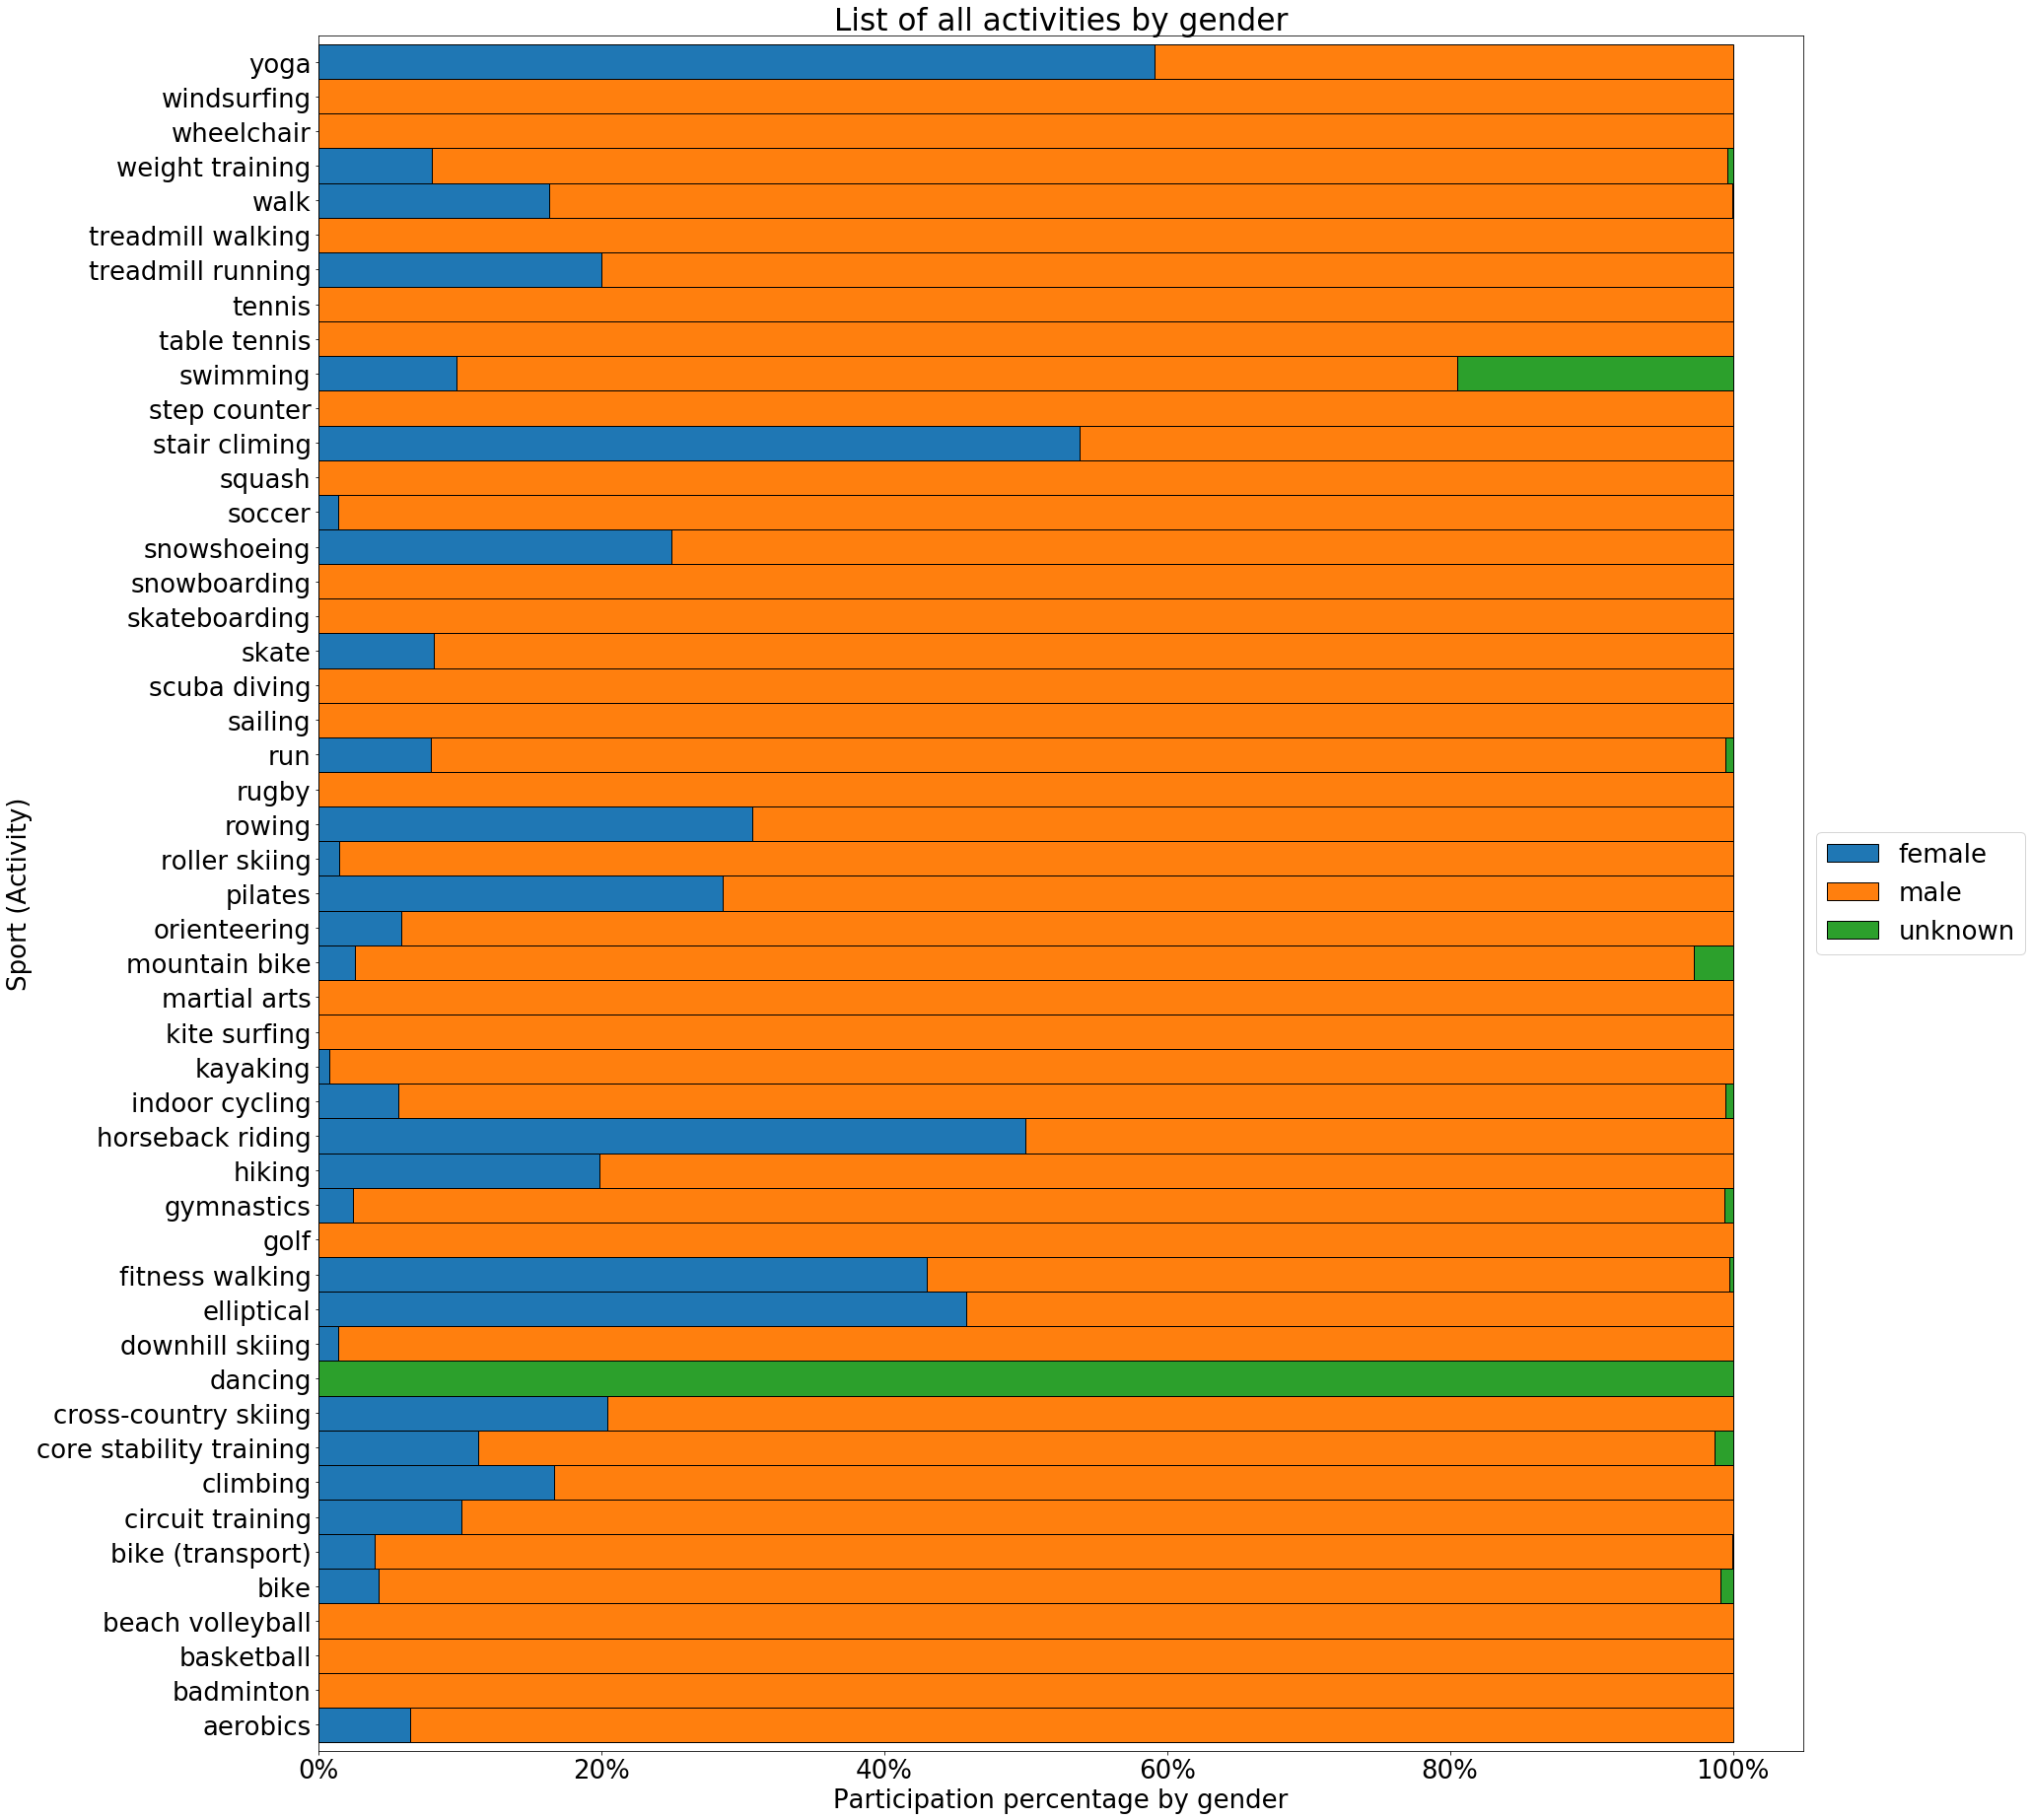

In [153]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
#userCount = df.select('userId').distinct().count()
activities = df.select('sport').distinct()
activityCount = activities.count()
#TO DO: average workouts by user
count = DataFrame([[activityCount]] ,columns= ['Sport (Activity) types'])
print('Activity count:')
count
print('\nList of all activities:')
#activities.toPandas()
activities_by_gender = df.groupBy('sport', 'gender').count().toPandas()
activities_by_gender_sum = activities_by_gender.set_index(['sport','gender']).unstack(level='gender', fill_value=0).reset_index()
#activities_by_gender_sum = activities_by_gender_sum.astype(int)
activities_by_gender_sum
print('\nSummarized activity participation by percentage of gender:')
fig = plt.figure(figsize=(27, 32))
grid_size = (1,1)

ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)


# source1: http://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot#stacked-bar-plot-with-group-by
# source2: https://towardsdatascience.com/a-guide-to-pandas-and-matplotlib-for-data-exploration-56fad95f951c
plot = activities_by_gender.groupby(['sport', 'gender']).agg(np.mean).groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', stacked=True, width=1
                , edgecolor='black', ax=ax, title='List of all activities by gender')
a= plt.ylabel('Sport (Activity)')
b= plt.xlabel('Participation percentage by gender')
c= plt.legend(sorted(activities_by_gender['gender'].unique()), loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.rcParams.update({'font.size': 26})
#plt.axes.xaxis.labelpad = 10
ax = plt.gca()
f = ax.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

#. Next, we will look further into each datarow and observe how many data points were record per activities <br />
*For a more detailed observation, we break down the record count per activity into each individual sport*

C:\Users\t_tu\Anaconda3\envs\bigdata-lab\lib\site-packages\pandas\plotting\_core.py:2396: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  yrot=yrot, **kwds)


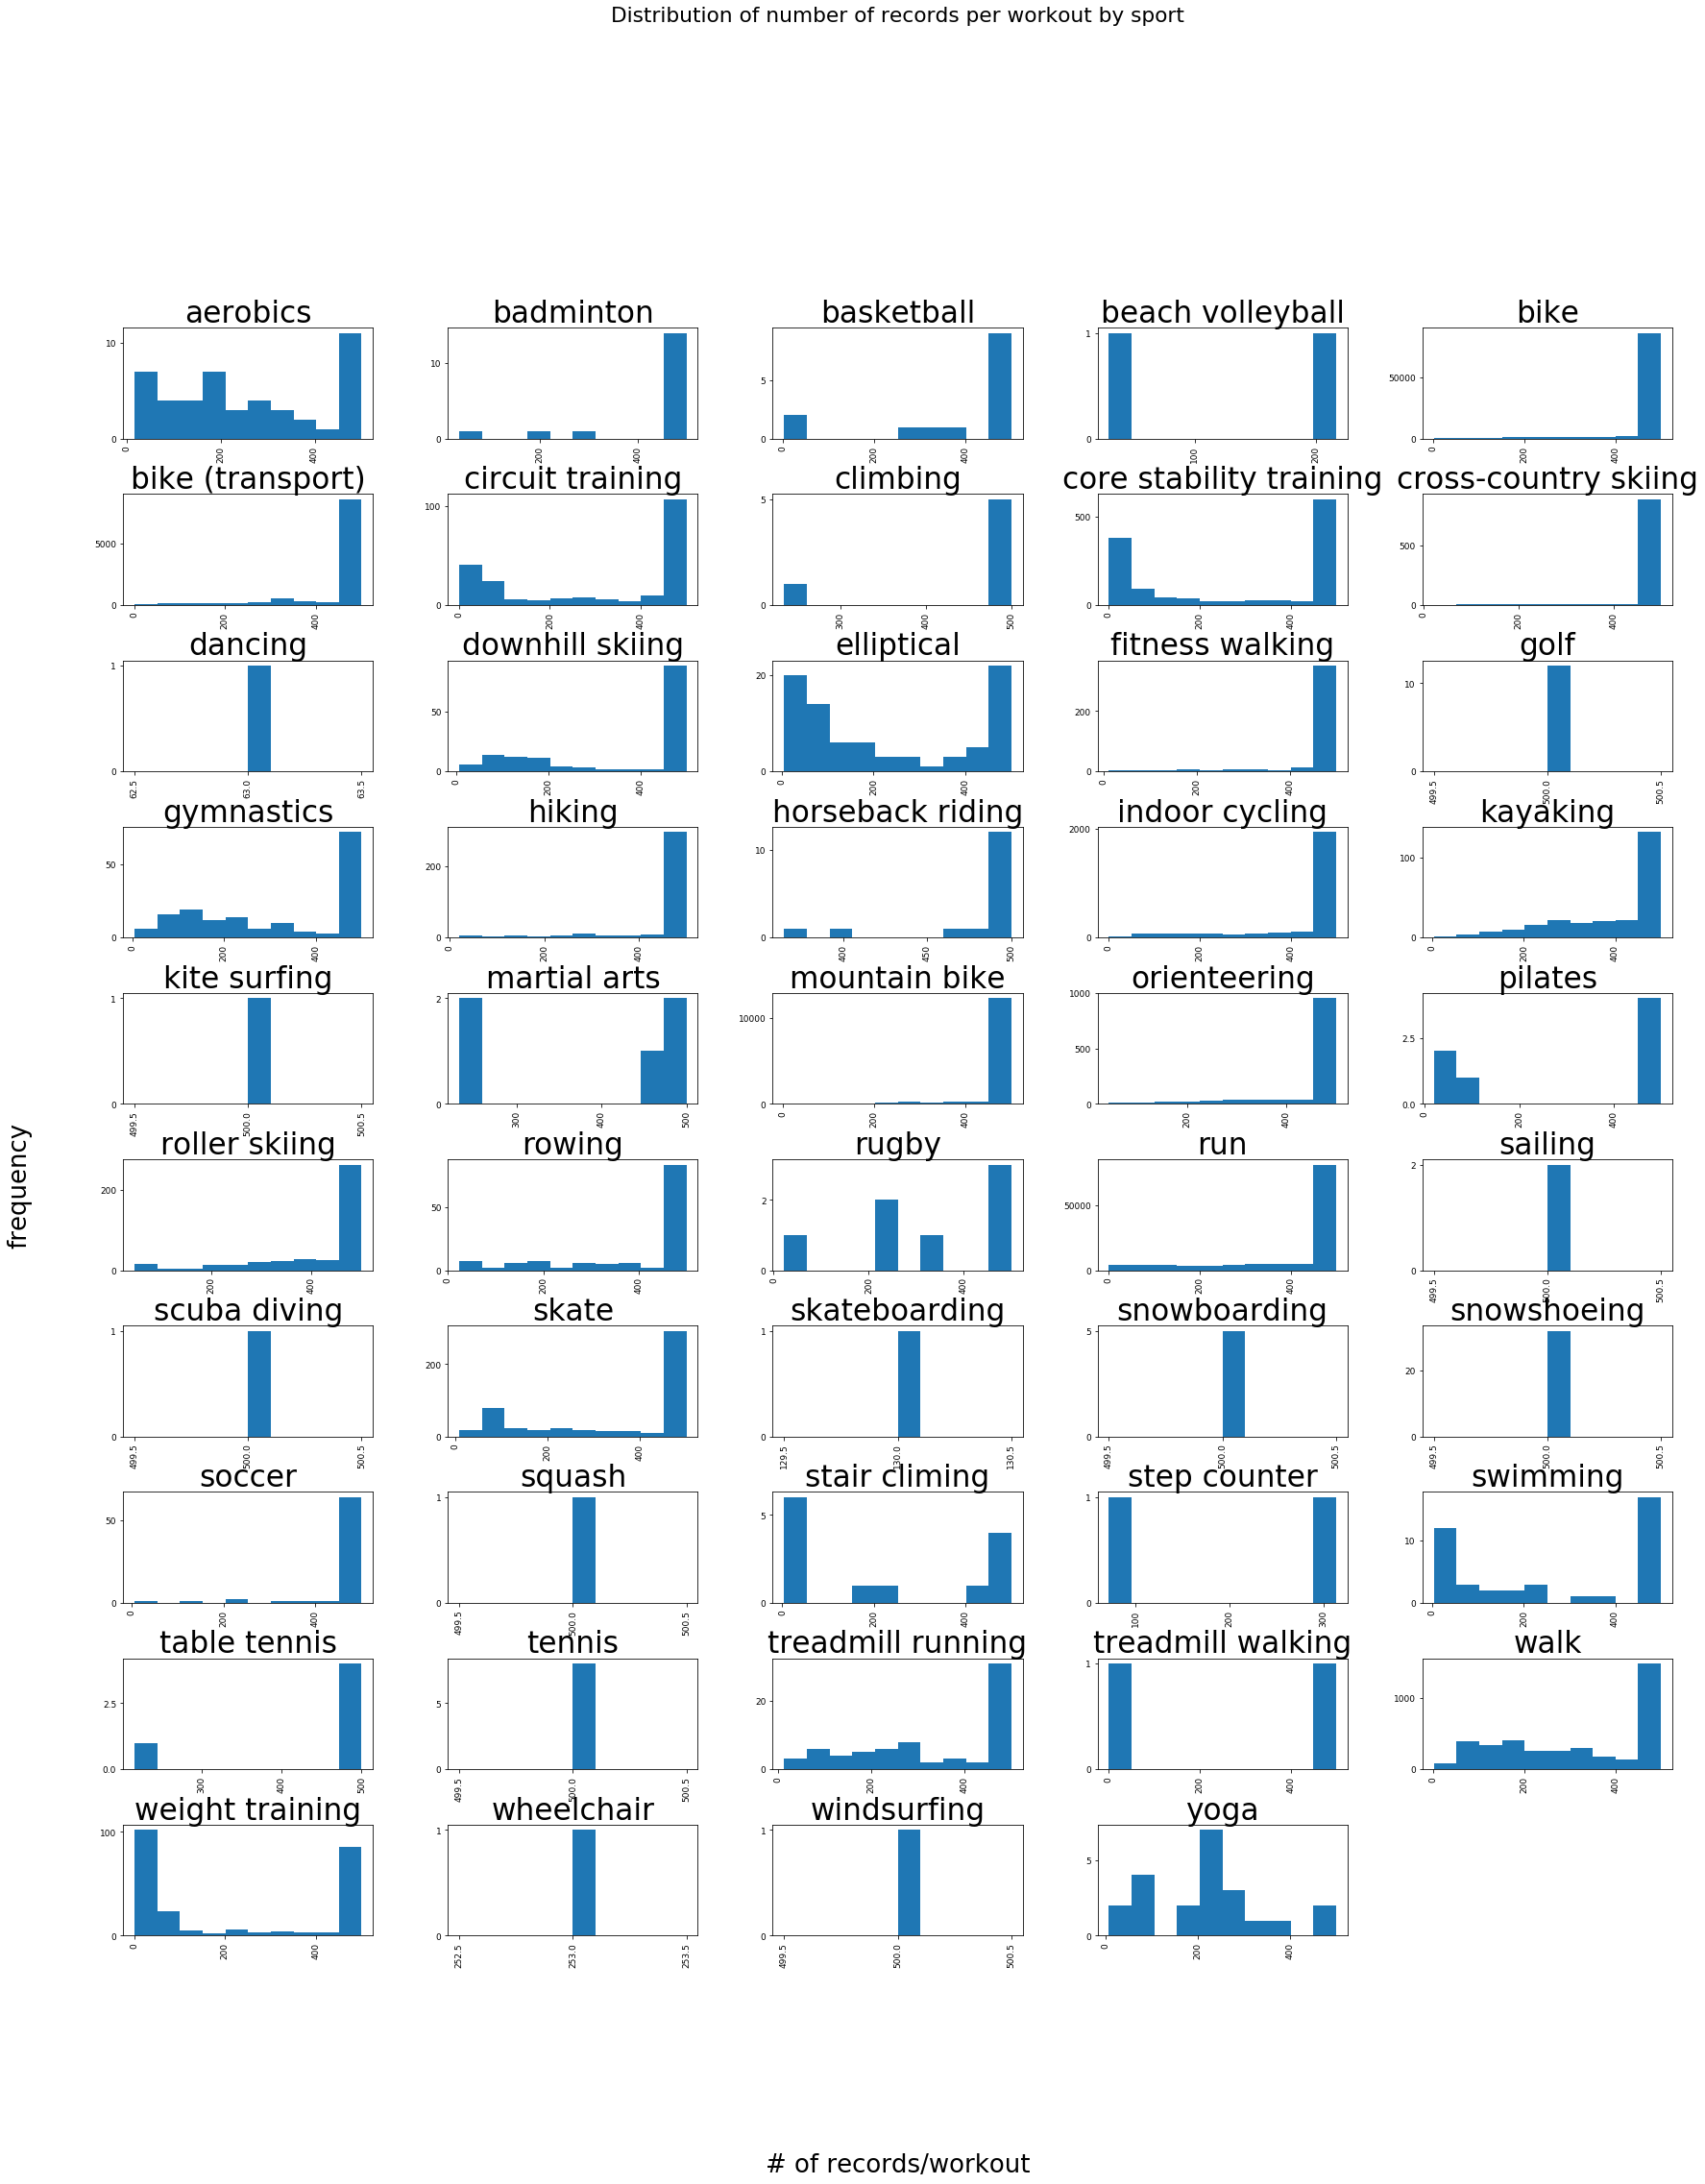

In [88]:
df = df.withColumn('PerWorkoutRecordCount', size(col('timestamp')))
fig = plt.figure(figsize=(28, 31)) #
grid_size = (10,5)
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
#fig, axes = plt.subplots()

PerWorkoutRecordCount_dist = df.select('PerWorkoutRecordCount', 'sport').toPandas().hist(
    column='PerWorkoutRecordCount', bins=10, sharex = False, grid=True, xlabelsize=9, ylabelsize=9, by='sport', ax = ax,
    layout = (10, 5), figsize=(4,6)
    )

#for ax in PerWorkoutRecordCount_dist.flatten():
#    a = ax.set_xlabel("# of records/workout")
#    b = ax.set_ylabel("Frequency")
z = plt.suptitle('Distribution of number of records per workout by sport', x=0.5, y=1.05, ha='center', fontsize='small')
y = fig.text(0.5, 0.04, '# of records/workout', ha='center')
z  =fig.text(0.04, 0.5, 'frequency', va='center', rotation='vertical')
#plt.show()



6. Next, we will have a first look at the heart_rate for each workout. <br /> 
*Due to the huge amount of users and workout numbers, we just picked randomly up to 3 users per gender, up to 10 workouts per activity type.
We also create a new column to change the raw timestamp values into python datetime format for use later*

In [126]:
from datetime import *
from pyspark.sql.types import *
from pyspark.sql.functions import udf

# Support function to convert a timestamp column into Datetime.Datetime, to be used for .withColumn function later
def to_time(timestamp_list):
    #date_time_list = [datetime.fromtimestamp(t) for t in timestamp_list]
    return [datetime.fromtimestamp(t) for t in timestamp_list]

# Register the support function 'to_time' as a user defined function into pyspark framwork
udf_to_time = udf(to_time, ArrayType(elementType=TimestampType()))

# Get unique list of userId and gender, for sampling purpose
users_genders = df.select('userId', 'gender').distinct().toPandas()
# Use 'sample' function to pick up to 3 userId per gender from the unique userId list
random_3_users_per_gender = users_genders.groupby('gender')['userId'].apply(lambda s: s.sample(min(len(s), 3)))

# Apply filter on the main pyspark dataframe for sampling
samples_by_gender = df.where(df.userId.isin(list(random_3_users_per_gender)))

# Next, generate the unique activity ids and sport types list from the sampled data set 
workout_sports = samples_by_gender.select('id', 'sport').distinct().toPandas()
# Use 'sample' function to pick up to 10 activity ids for each kind of sport 
random_10_workouts_per_sport = workout_sports.groupby('sport')['id'].apply(lambda s: s.sample(min(len(s), 10)))

# Apply filter to the sampled dataset to continue reduce the number of workouts per activity type
samples_by_gender_and_sport = samples_by_gender.where(df.id.isin(list(random_10_workouts_per_sport)))

# Create new 'date_time' column to convert from timestamp into python's datetime format for later usage
samples_by_gender_and_sport = samples_by_gender_and_sport.withColumn(
    'date_time', 
    udf_to_time('timestamp'))
pd_df = samples_by_gender_and_sport.toPandas()



All preparations have been done, let's plot heart rate on the sample data set! <br />
*Note: from this first look, the heart rate and workout time of a day is quite varied per user and activity. We convert the datetime to time value to use for the plot*

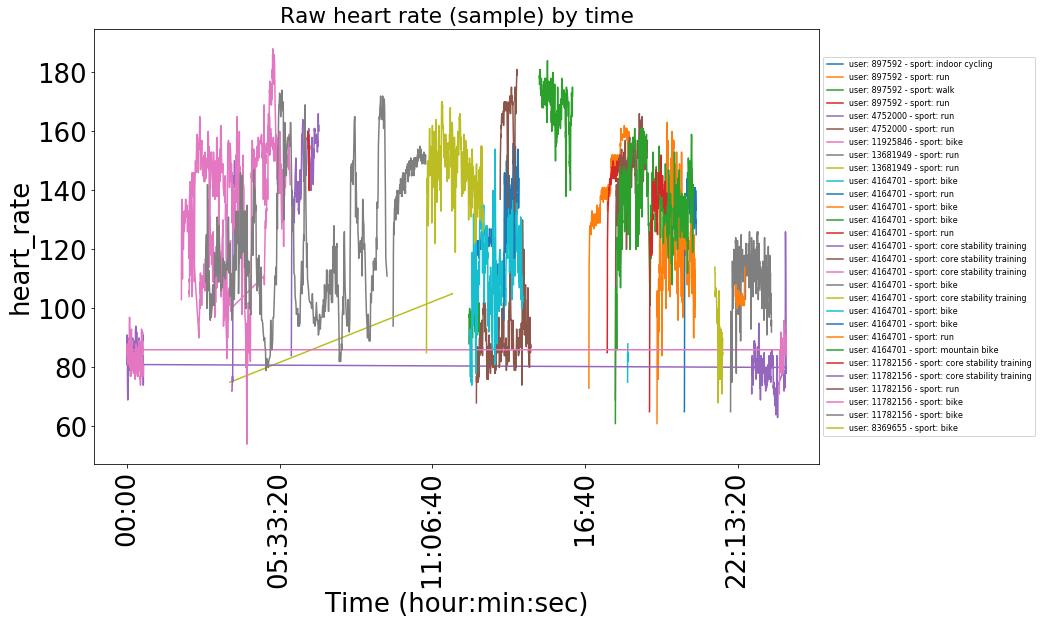

In [155]:
fig = plt.figure(figsize=(13, 8))
for index,data_row in pd_df.iterrows():
    data_row['date_time'] = [date_time.time() for date_time in data_row['date_time']]
    label = 'user: ' + str(data_row['userId']) + ' - sport: ' + data_row['sport']
    a= plt.plot(data_row['date_time'], data_row['heart_rate'], label=label)

a = plt.title('Raw heart rate (sample) by time',fontsize='small')
b = plt.xticks(rotation='vertical')
c = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), prop={'size': 8})
a= plt.ylabel('heart_rate')
b= plt.xlabel('Time (hour:min:sec)')
